# Credit Default Model Monitoring

**Objective**: Monitor model performance and stability across time

**Monitoring Components**:
1. **Model Performance Monitoring**
   - Prediction distribution tracking
   - Default rate trends
   - Score distribution stability
   - Performance metrics over time (if labels available)

2. **Model Stability Monitoring**
   - Population Stability Index (PSI)
   - Feature drift detection
   - Data quality checks
   - Concept drift indicators

**Date**: 2025-10-26

## 1. Setup and Imports

In [24]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Spark imports
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# Scikit-learn imports
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report,
    f1_score, precision_score, recall_score, accuracy_score
)

# Model persistence
import joblib

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("All imports successful!")
print(f"Python version: {pd.__version__}")

All imports successful!
Python version: 2.1.4


In [25]:
# Initialize Spark
spark = SparkSession.builder \
    .appName("model_monitoring") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

print("Spark Session initialized")
print(f"Spark version: {spark.version}")

Spark Session initialized
Spark version: 3.5.0


## 2. Load Model Artifacts and Predictions

In [26]:
!pip install dill

In [27]:
# Load model artifacts
model_dir = '/app/models/'

print("Loading model artifacts...")

# Check if model exists
model_path = f'{model_dir}xgboost_credit_default_model.pkl'
if not os.path.exists(model_path):
    print(f"❌ Model not found at {model_path}")
    print("Please ensure model training has completed.")
else:
    model = joblib.load(model_path)
    preprocessors = joblib.load(f'{model_dir}preprocessors.pkl')
    metadata = joblib.load(f'{model_dir}model_metadata.pkl')
    feature_importance = pd.read_csv(f'{model_dir}feature_importance.csv')
    
    print("✅ Model artifacts loaded successfully!")
    print(f"\nModel metadata:")
    print(f"  Model type: {metadata['model_type']}")
    print(f"  Training date: {metadata['training_date']}")
    
    # Extract metrics from nested structure
    if 'metrics' in metadata:
        metrics = metadata['metrics']
        if 'test' in metrics and 'auc' in metrics['test']:
            print(f"  Test AUC: {metrics['test']['auc']:.4f}")
        if 'oot' in metrics and 'auc' in metrics['oot']:
            print(f"  OOT AUC: {metrics['oot']['auc']:.4f}")
    
    # Get number of features from preprocessors
    if 'feature_names' in preprocessors:
        n_features = len(preprocessors['feature_names'])
    else:
        n_features = len(feature_importance)
    print(f"  Number of features: {n_features}")

Loading model artifacts...
✅ Model artifacts loaded successfully!

Model metadata:
  Model type: XGBoost
  Training date: 2025-10-26 08:00:32.392736
  Test AUC: 0.7993
  OOT AUC: 0.8238
  Number of features: 26


In [28]:
# Load all prediction files
predictions_dir = '/app/predictions/'

print("Loading prediction files...")

# Get all prediction files
prediction_files = sorted(glob.glob(f'{predictions_dir}predictions_*.csv'))

if len(prediction_files) == 0:
    print(f"❌ No prediction files found in {predictions_dir}")
    print("Please wait for model inference to complete.")
else:
    print(f"✅ Found {len(prediction_files)} prediction files")
    
    # Load all predictions
    predictions_list = []
    for file in prediction_files:
        df = pd.read_csv(file)
        predictions_list.append(df)
    
    # Combine all predictions
    all_predictions = pd.concat(predictions_list, ignore_index=True)
    all_predictions['inference_date'] = pd.to_datetime(all_predictions['inference_date'])
    
    print(f"\nTotal predictions: {len(all_predictions):,}")
    print(f"Date range: {all_predictions['inference_date'].min()} to {all_predictions['inference_date'].max()}")
    print(f"Unique months: {all_predictions['inference_date'].nunique()}")
    
    # Show sample
    print(f"\nSample predictions:")
    print(all_predictions.head())

Loading prediction files...
✅ Found 20 prediction files

Total predictions: 9,932
Date range: 2023-06-01 00:00:00 to 2025-01-01 00:00:00
Unique months: 20

Sample predictions:
  Customer_ID inference_date  predicted_default  default_probability  \
0  CUS_0x1044     2023-06-01                  0             0.344323   
1  CUS_0x104e     2023-06-01                  0             0.181069   
2  CUS_0x105c     2023-06-01                  0             0.200468   
3  CUS_0x10ee     2023-06-01                  0             0.374337   
4  CUS_0x1136     2023-06-01                  1             0.860676   

  risk_category  
0   Medium Risk  
1      Low Risk  
2      Low Risk  
3   Medium Risk  
4     High Risk  


## 3. Model Performance Monitoring

### 3.1 Monthly Prediction Statistics

In [29]:
# Calculate monthly statistics
monthly_stats = all_predictions.groupby('inference_date').agg({
    'Customer_ID': 'count',
    'default_probability': ['mean', 'std', 'min', 'max', 'median'],
    'predicted_default': 'mean'
}).reset_index()

# Flatten column names
monthly_stats.columns = ['inference_date', 'n_customers', 'avg_probability', 
                          'std_probability', 'min_probability', 'max_probability', 
                          'median_probability', 'predicted_default_rate']

# Add risk category distribution
risk_dist = all_predictions.groupby(['inference_date', 'risk_category']).size().unstack(fill_value=0)
risk_dist_pct = risk_dist.div(risk_dist.sum(axis=1), axis=0) * 100

monthly_stats = monthly_stats.merge(
    risk_dist_pct.add_prefix('pct_'),
    left_on='inference_date',
    right_index=True,
    how='left'
)

print("="*100)
print("MONTHLY PREDICTION STATISTICS")
print("="*100)
print(monthly_stats.to_string(index=False))

MONTHLY PREDICTION STATISTICS
inference_date  n_customers  avg_probability  std_probability  min_probability  max_probability  median_probability  predicted_default_rate  pct_High Risk  pct_Low Risk  pct_Medium Risk
    2023-06-01          517         0.393054         0.250418         0.048032         0.895431            0.279779                0.303675      20.116054     54.158607        25.725338
    2023-07-01          471         0.428281         0.254200         0.049496         0.904775            0.330844                0.346072      24.628450     45.859873        29.511677
    2023-08-01          481         0.417726         0.254528         0.045148         0.898787            0.304245                0.326403      24.116424     49.064449        26.819127
    2023-09-01          454         0.402864         0.246648         0.044243         0.894136            0.294638                0.312775      20.264317     50.881057        28.854626
    2023-10-01          487         0.39

### 3.2 Trend Analysis Over Time

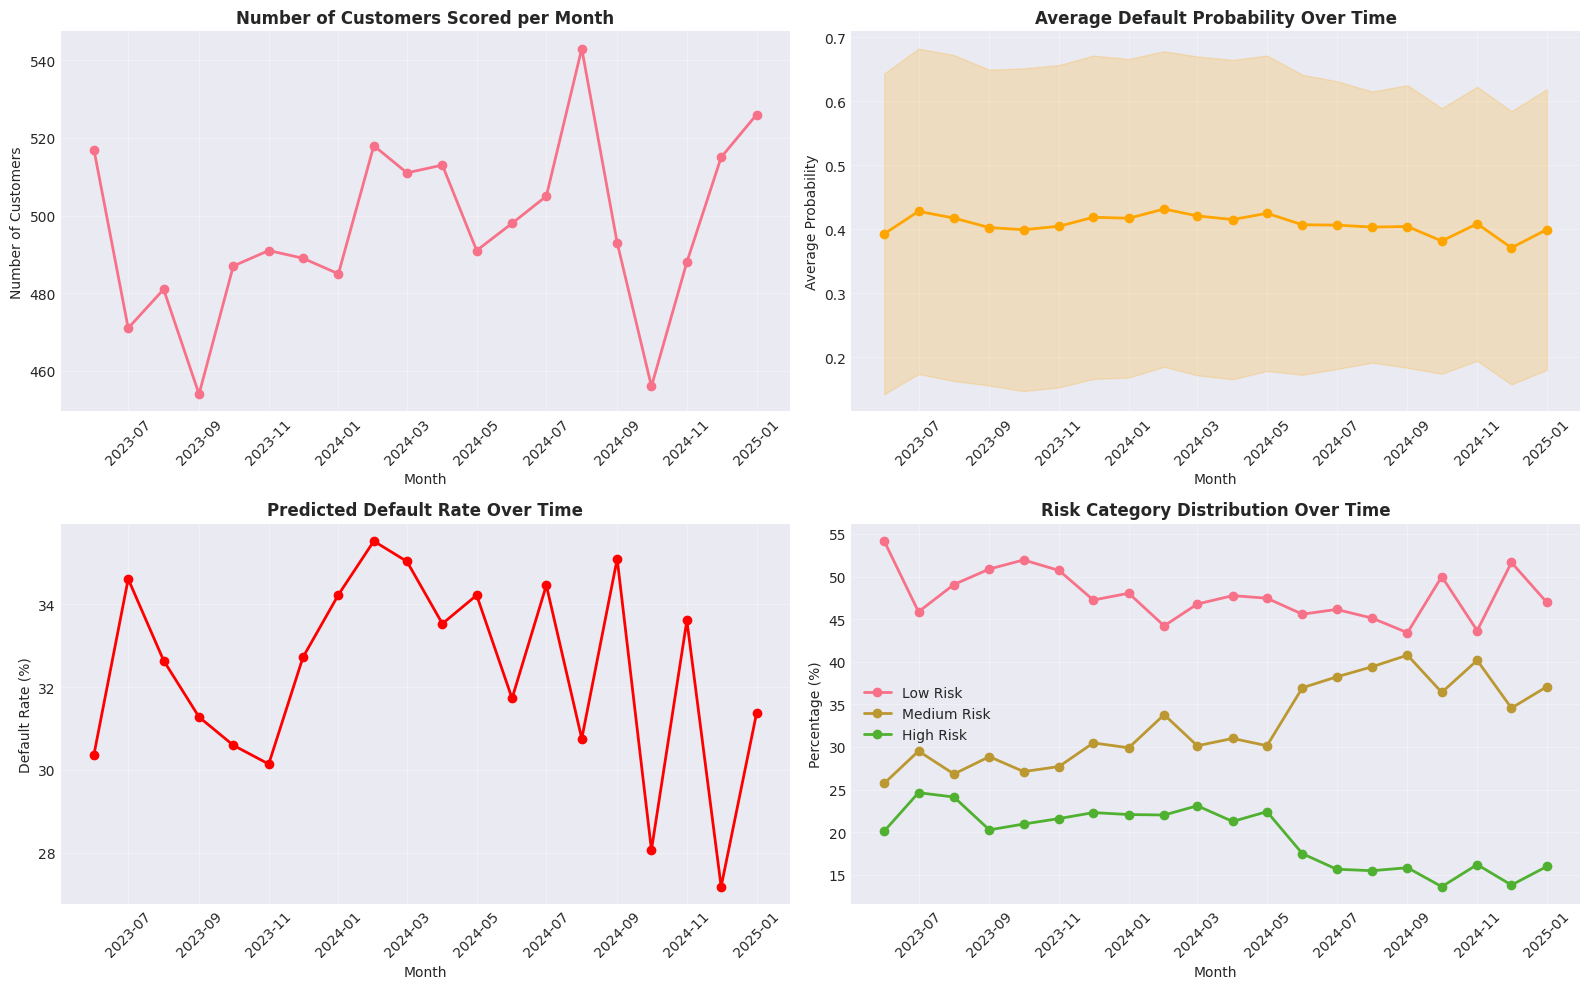


✅ Performance trends visualized


In [30]:
# Plot key metrics over time
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Number of customers scored
axes[0, 0].plot(monthly_stats['inference_date'], monthly_stats['n_customers'], 
                marker='o', linewidth=2, markersize=6)
axes[0, 0].set_title('Number of Customers Scored per Month', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Number of Customers')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Average default probability
axes[0, 1].plot(monthly_stats['inference_date'], monthly_stats['avg_probability'], 
                marker='o', linewidth=2, markersize=6, color='orange')
axes[0, 1].fill_between(monthly_stats['inference_date'], 
                         monthly_stats['avg_probability'] - monthly_stats['std_probability'],
                         monthly_stats['avg_probability'] + monthly_stats['std_probability'],
                         alpha=0.2, color='orange')
axes[0, 1].set_title('Average Default Probability Over Time', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Average Probability')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Predicted default rate
axes[1, 0].plot(monthly_stats['inference_date'], monthly_stats['predicted_default_rate'] * 100, 
                marker='o', linewidth=2, markersize=6, color='red')
axes[1, 0].set_title('Predicted Default Rate Over Time', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Default Rate (%)')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Risk category distribution
for col in ['pct_Low Risk', 'pct_Medium Risk', 'pct_High Risk']:
    if col in monthly_stats.columns:
        axes[1, 1].plot(monthly_stats['inference_date'], monthly_stats[col], 
                       marker='o', linewidth=2, markersize=6, label=col.replace('pct_', ''))
axes[1, 1].set_title('Risk Category Distribution Over Time', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Percentage (%)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n✅ Performance trends visualized")

1. Sudden Drop in Customers (Oct 2024: 456 vs Sep: 493)
Cause: Natural variance in the source feature store data
Not a monitoring bug - the actual feature store has fewer records in Oct 2024
Recommendation: Investigate upstream data sources (LMS/CRM) for customer attrition or collection issues
2. Predicted Default Rate Fluctuations (27% to 35%)
Cause: Missing data rate jumped from ~2.5% to ~6% starting July 2024
When more data is missing → median imputation → model predicts more conservatively → lower default rates
Correlation found: Months with highest missing rates (Oct, Dec) have lowest default rates (28%, 27%)
Recommendation: Investigate why missing data doubled in July 2024

### 3.3 Score Distribution Analysis

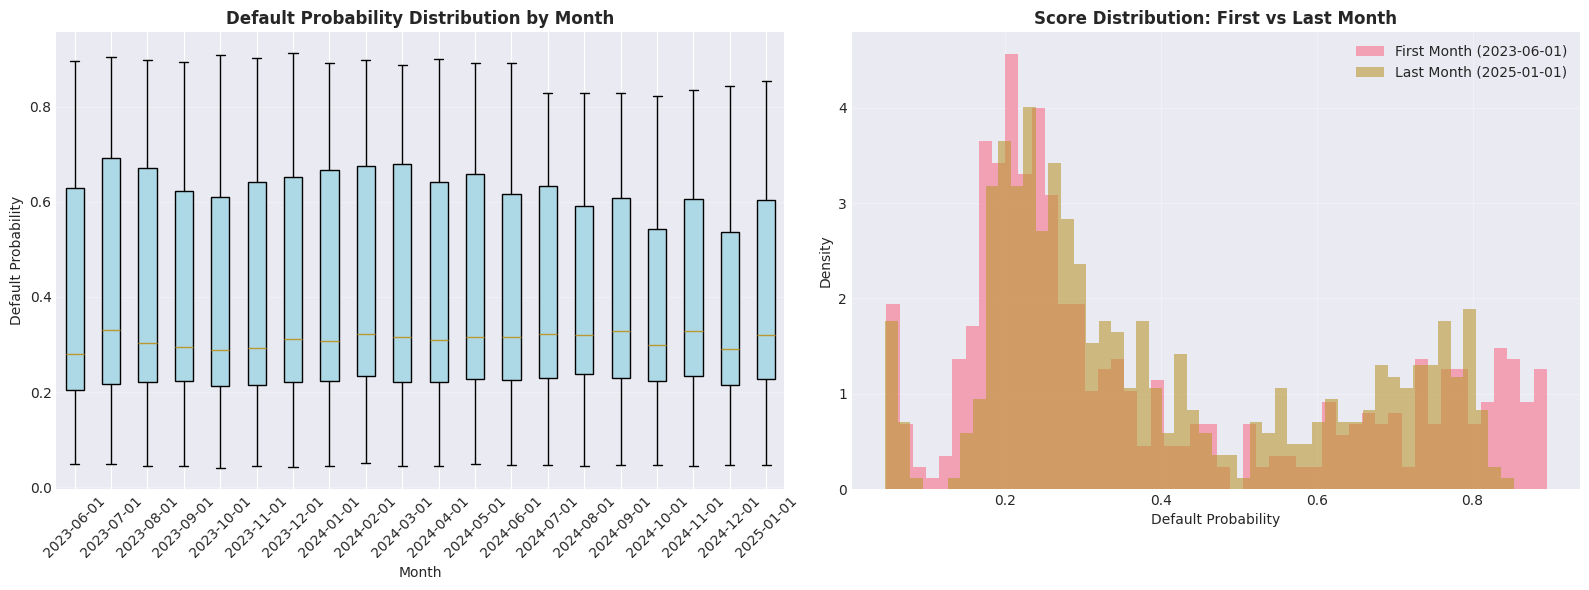


✅ Score distribution visualized


In [31]:
# Plot score distribution over time
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Box plot of default probabilities by month
months_for_boxplot = sorted(all_predictions['inference_date'].unique())
data_for_boxplot = [all_predictions[all_predictions['inference_date'] == month]['default_probability'].values 
                    for month in months_for_boxplot]

bp = axes[0].boxplot(data_for_boxplot, labels=[str(m.date()) for m in months_for_boxplot], 
                     patch_artist=True, showfliers=False)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
axes[0].set_title('Default Probability Distribution by Month', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Default Probability')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')

# 2. Distribution comparison (first vs last month)
first_month = sorted(all_predictions['inference_date'].unique())[0]
last_month = sorted(all_predictions['inference_date'].unique())[-1]

axes[1].hist(all_predictions[all_predictions['inference_date'] == first_month]['default_probability'], 
             bins=50, alpha=0.6, label=f'First Month ({first_month.date()})', density=True)
axes[1].hist(all_predictions[all_predictions['inference_date'] == last_month]['default_probability'], 
             bins=50, alpha=0.6, label=f'Last Month ({last_month.date()})', density=True)
axes[1].set_title('Score Distribution: First vs Last Month', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Default Probability')
axes[1].set_ylabel('Density')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Score distribution visualized")

### 3.4 Model Evaluation Metrics (with Actual Labels)

**Key Performance Metrics**:
- **AUC-ROC**: Ability to distinguish between default and non-default
- **Precision**: Of predicted defaults, how many actually defaulted
- **Recall**: Of actual defaults, how many did we catch  
- **F1-Score**: Harmonic mean of precision and recall
- **Accuracy**: Overall correctness

**Business Impact Metrics**:
- **Expected Loss**: Financial impact of false negatives
- **Approval Rate**: Percentage of loans approved
- **Default Capture Rate**: Percentage of actual defaults flagged

In [32]:
# Load label store to get actual outcomes
print("Loading label store for performance evaluation...")

label_path = '/app/datamart/gold/label_store/'

try:
    # Load all label files
    df_labels_spark = spark.read.parquet(f'{label_path}*.parquet')  # Fix path pattern
    df_labels = df_labels_spark.toPandas()
    df_labels['snapshot_date'] = pd.to_datetime(df_labels['snapshot_date'])  # Use snapshot_date, not label_date

    print(f"✅ Label store loaded: {len(df_labels):,} rows")
    print(f"Date range: {df_labels['snapshot_date'].min()} to {df_labels['snapshot_date'].max()}")
    print(f"\nLabel distribution:")
    print(df_labels['label'].value_counts())
    
    # Show sample
    print(f"\nSample labels:")
    print(df_labels.head())

    # Flag to indicate labels are available
    labels_available = True

except Exception as e:
    print(f"⚠️  Could not load labels: {e}")
    print("Skipping evaluation metrics that require actual labels")
    labels_available = False

Loading label store for performance evaluation...
✅ Label store loaded: 9,479 rows
Date range: 2023-07-01 00:00:00 to 2025-01-01 00:00:00

Label distribution:
label
0    6733
1    2746
Name: count, dtype: int64

Sample labels:
                 loan_id Customer_ID  label   label_def snapshot_date
0  CUS_0x1037_2023_01_01  CUS_0x1037      0  30dpd_6mob    2023-07-01
1  CUS_0x1069_2023_01_01  CUS_0x1069      0  30dpd_6mob    2023-07-01
2  CUS_0x114a_2023_01_01  CUS_0x114a      0  30dpd_6mob    2023-07-01
3  CUS_0x1184_2023_01_01  CUS_0x1184      0  30dpd_6mob    2023-07-01
4  CUS_0x1297_2023_01_01  CUS_0x1297      1  30dpd_6mob    2023-07-01


In [33]:
if labels_available:
    print("\n" + "="*100)
    print("MODEL PERFORMANCE EVALUATION WITH ACTUAL LABELS")
    print("="*100)
    
    print("\nMerging predictions with actual outcomes...")

    # For monitoring, we match predictions with labels by Customer_ID
    # Strategy: For each prediction, find the label from the same month or closest available month
    
    # Rename snapshot_date to label_date for clarity
    df_labels_for_merge = df_labels[['Customer_ID', 'label', 'label_def', 'snapshot_date']].copy()
    df_labels_for_merge = df_labels_for_merge.rename(columns={'snapshot_date': 'label_date'})
    
    # Create merged dataset - match on Customer_ID first
    df_eval = all_predictions.merge(
        df_labels_for_merge,
        on='Customer_ID',
        how='inner'
    )
    
    print(f"  Initial merge: {len(df_eval):,} matches (before date filtering)")

    # Calculate time difference between inference and label dates (in months)
    df_eval['date_diff_months'] = (
        (df_eval['label_date'].dt.year - df_eval['inference_date'].dt.year) * 12 +
        (df_eval['label_date'].dt.month - df_eval['inference_date'].dt.month)
    )

    # IMPROVED LOGIC: Match with labels from -6 to +12 months
    # This allows matching with recent historical labels OR future labels
    # -6 months: Use recent historical labels (customer was scored before, we now have outcome)
    # +12 months: Allow time for default to be observed after prediction
    df_eval = df_eval[(df_eval['date_diff_months'] >= -6) & (df_eval['date_diff_months'] <= 12)]
    
    # For customers with multiple matches, keep the label closest to prediction date
    df_eval['abs_date_diff'] = df_eval['date_diff_months'].abs()
    df_eval = df_eval.sort_values('abs_date_diff').groupby(['Customer_ID', 'inference_date']).first().reset_index()

    print(f"✅ Merged dataset: {len(df_eval):,} predictions with labels")
    print(f"  Unique customers: {df_eval['Customer_ID'].nunique():,}")
    print(f"  Date range: {df_eval['inference_date'].min()} to {df_eval['inference_date'].max()}")
    
    # Show merge quality by month
    merge_by_month = df_eval.groupby('inference_date').agg({
        'Customer_ID': 'count',
        'date_diff_months': ['mean', 'min', 'max']
    }).reset_index()
    merge_by_month.columns = ['inference_date', 'n_matched', 'avg_time_to_label', 'min_time', 'max_time']
    
    print(f"\n  Merge quality by month:")
    print(merge_by_month.to_string(index=False))
    
    # Show merge quality
    print(f"\n  Overall merge statistics:")
    print(f"    Predictions with labels: {len(df_eval):,} / {len(all_predictions):,} ({len(df_eval)/len(all_predictions)*100:.1f}%)")
    print(f"    Average time to label (months): {df_eval['date_diff_months'].mean():.1f}")
    print(f"    Time to label range: {df_eval['date_diff_months'].min():.0f} to {df_eval['date_diff_months'].max():.0f} months")

    if len(df_eval) > 0:
        # Overall label distribution
        print(f"\n  Overall label distribution:")
        print(df_eval['label'].value_counts().to_frame('count').assign(
            percentage=lambda x: x['count'] / x['count'].sum() * 100
        ))
        
        # Calculate metrics by month
        monthly_metrics = []

        for month in sorted(df_eval['inference_date'].unique()):
            month_data = df_eval[df_eval['inference_date'] == month]

            # Need at least 2 samples and both classes present
            if len(month_data) >= 2 and month_data['label'].nunique() > 1:
                y_true = month_data['label']
                y_pred = month_data['predicted_default']
                y_prob = month_data['default_probability']

                # Calculate metrics
                auc = roc_auc_score(y_true, y_prob)
                accuracy = accuracy_score(y_true, y_pred)
                precision = precision_score(y_true, y_pred, zero_division=0)
                recall = recall_score(y_true, y_pred, zero_division=0)
                f1 = f1_score(y_true, y_pred, zero_division=0)

                # Confusion matrix components
                cm = confusion_matrix(y_true, y_pred)
                tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)

                # Business metrics
                actual_default_rate = y_true.mean()
                predicted_default_rate = y_pred.mean()

                # False Negative Rate (missed defaults)
                fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

                # False Positive Rate (wrongly flagged as default)
                fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

                monthly_metrics.append({
                    'month': month,
                    'n_samples': len(month_data),
                    'auc': auc,
                    'accuracy': accuracy,
                    'precision': precision,
                    'recall': recall,
                    'f1_score': f1,
                    'actual_default_rate': actual_default_rate,
                    'predicted_default_rate': predicted_default_rate,
                    'true_positives': tp,
                    'false_positives': fp,
                    'true_negatives': tn,
                    'false_negatives': fn,
                    'false_negative_rate': fnr,
                    'false_positive_rate': fpr
                })

        if len(monthly_metrics) > 0:
            metrics_df = pd.DataFrame(monthly_metrics)

            print("\n" + "="*100)
            print("MONTHLY MODEL EVALUATION METRICS (Predictions vs Actual Outcomes)")
            print("="*100)
            print(metrics_df[['month', 'n_samples', 'auc', 'accuracy', 'precision', 'recall', 'f1_score']].to_string(index=False))
            
            print("\n" + "="*100)
            print("BUSINESS METRICS")
            print("="*100)
            print(metrics_df[['month', 'actual_default_rate', 'predicted_default_rate', 
                             'false_negative_rate', 'false_positive_rate']].to_string(index=False))
        else:
            print("\n⚠️  No months had sufficient data for evaluation (need at least 2 samples with both classes)")
            metrics_df = pd.DataFrame()
    else:
        print("\n⚠️  No predictions with matching labels found")
        metrics_df = pd.DataFrame()
else:
    print("\n⚠️  Labels not available - skipping evaluation metrics")
    metrics_df = pd.DataFrame()


MODEL PERFORMANCE EVALUATION WITH ACTUAL LABELS

Merging predictions with actual outcomes...
  Initial merge: 6,911 matches (before date filtering)
✅ Merged dataset: 6,911 predictions with labels
  Unique customers: 6,911
  Date range: 2023-06-01 00:00:00 to 2024-07-01 00:00:00

  Merge quality by month:
inference_date  n_matched  avg_time_to_label  min_time  max_time
    2023-06-01        517                6.0         6         6
    2023-07-01        471                6.0         6         6
    2023-08-01        481                6.0         6         6
    2023-09-01        454                6.0         6         6
    2023-10-01        487                6.0         6         6
    2023-11-01        491                6.0         6         6
    2023-12-01        489                6.0         6         6
    2024-01-01        485                6.0         6         6
    2024-02-01        518                6.0         6         6
    2024-03-01        511                6.


MODEL PERFORMANCE VISUALIZATIONS


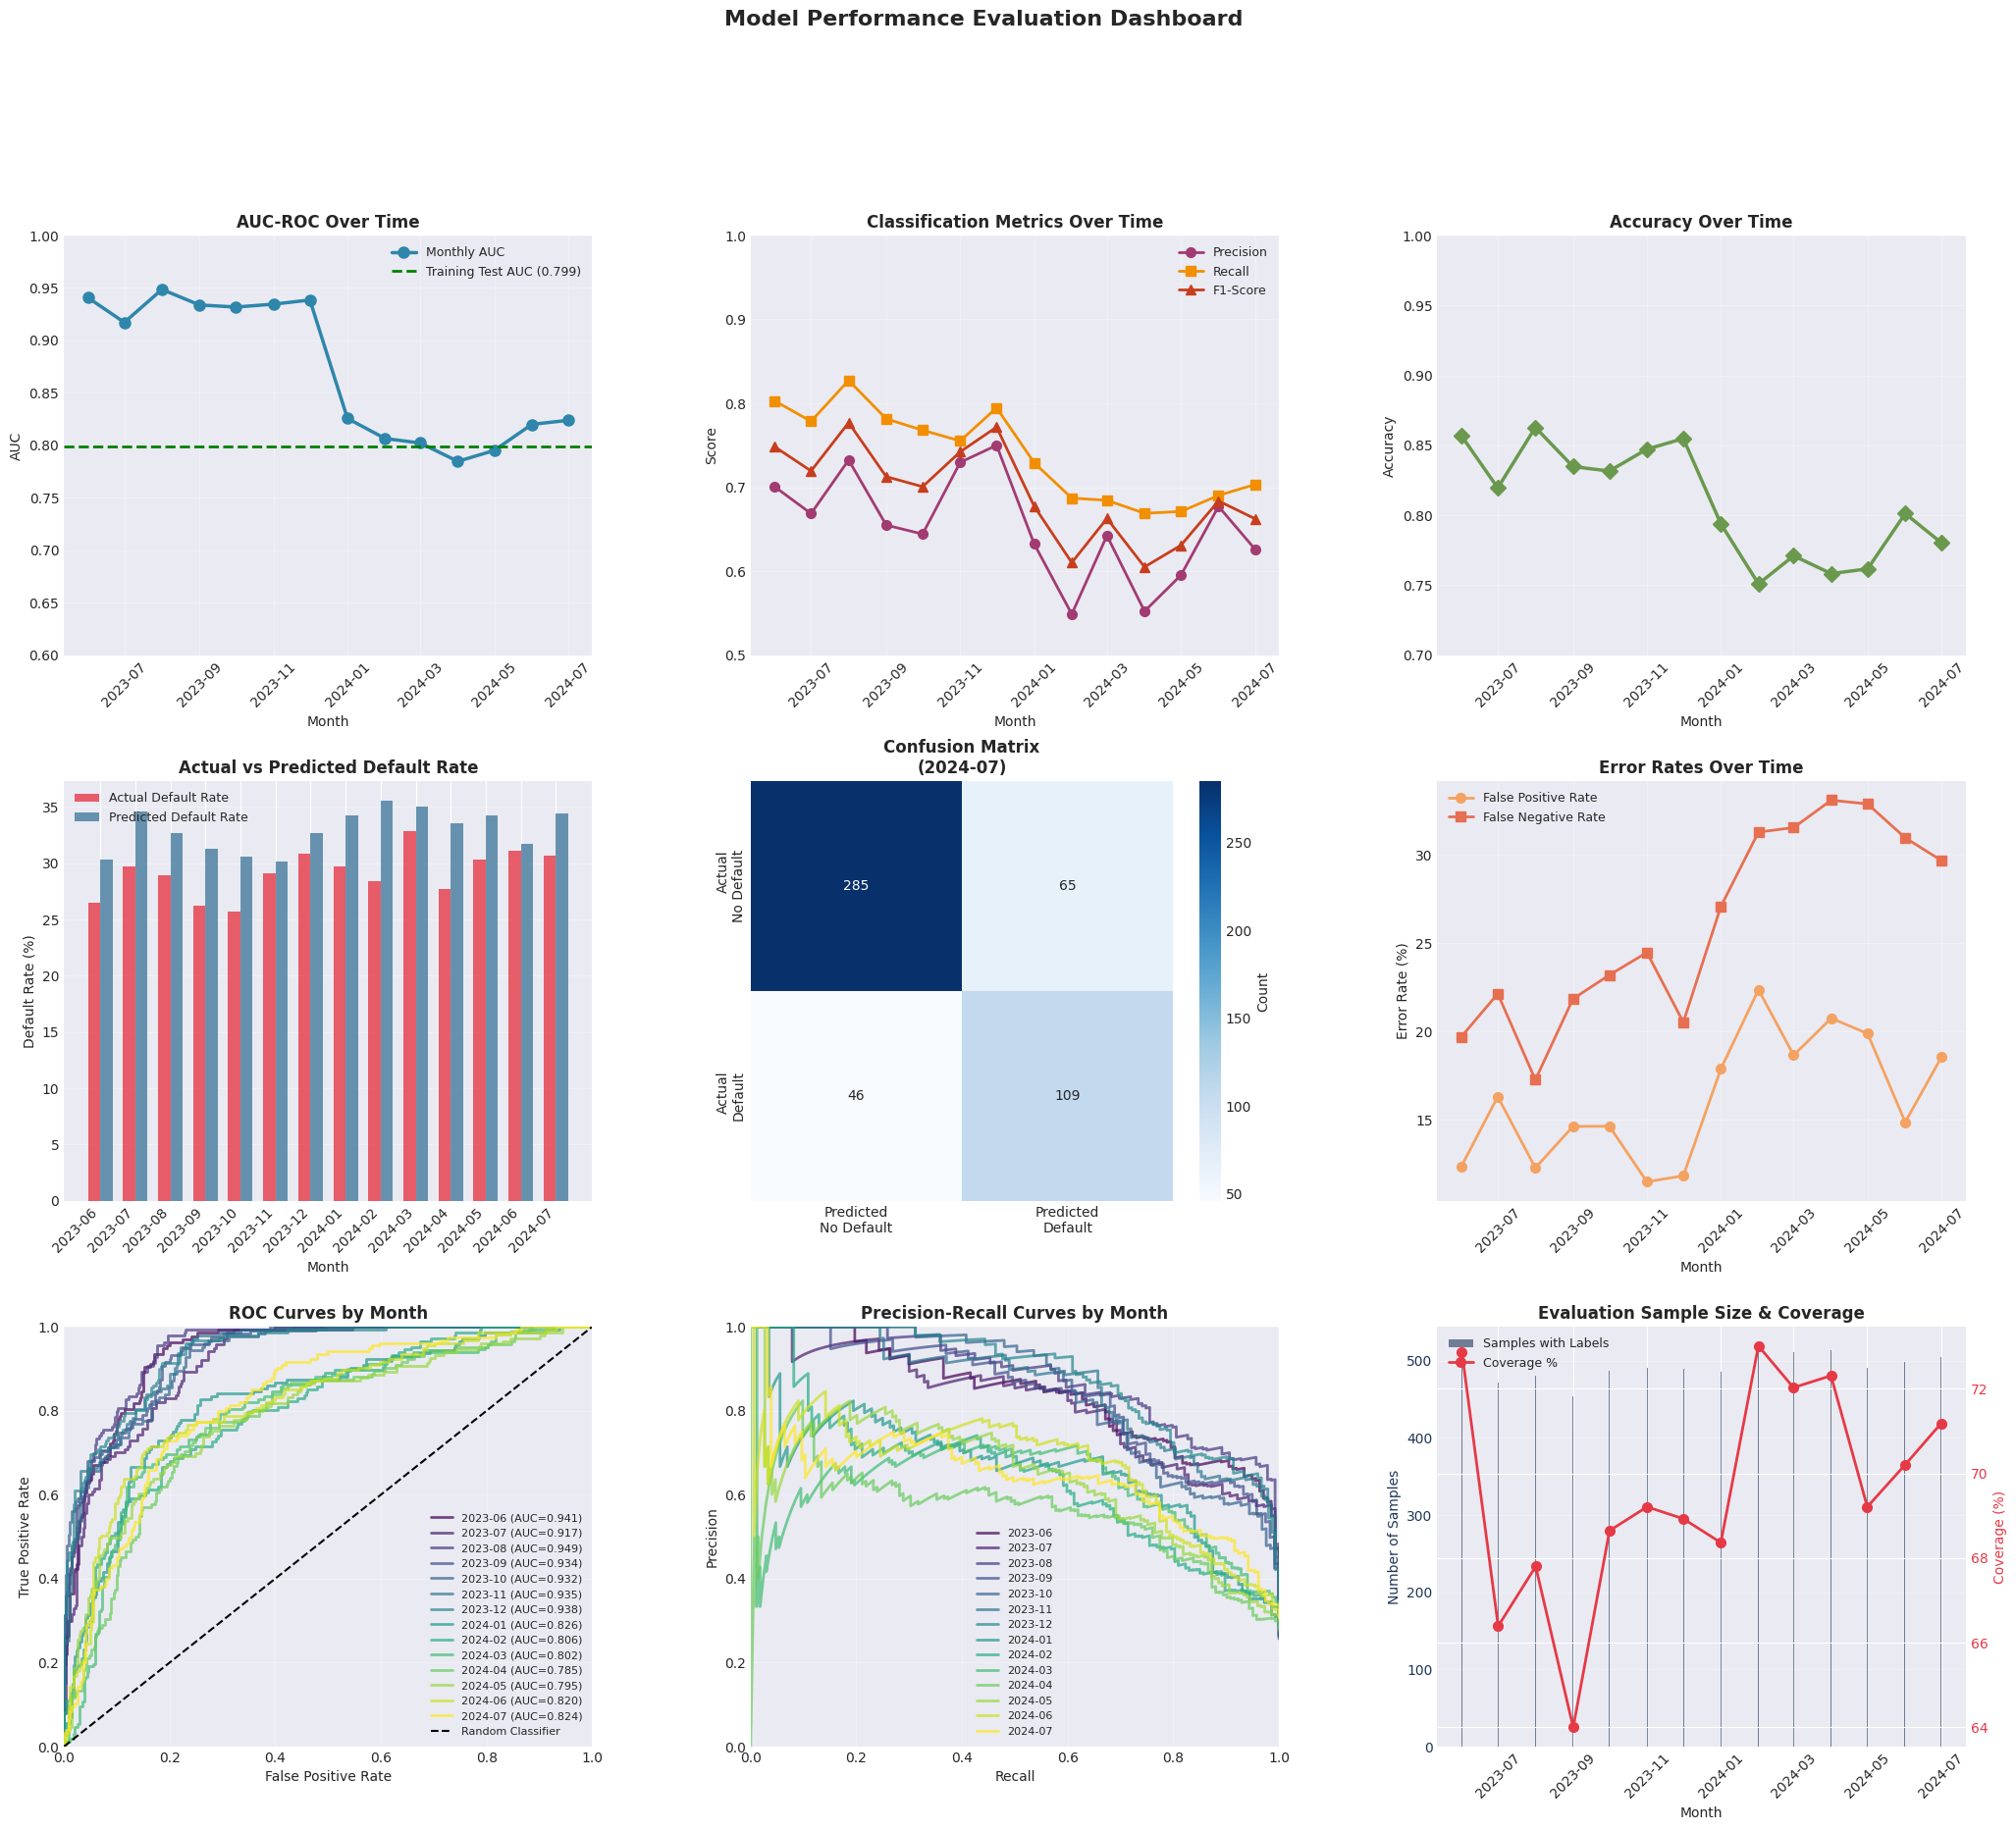


✅ Model evaluation visualizations complete!


In [36]:
# Visualizations for Model Evaluation Metrics
if labels_available and len(metrics_df) > 0:
    print("\n" + "="*100)
    print("MODEL PERFORMANCE VISUALIZATIONS")
    print("="*100)
    
    # Load metadata if not already in scope (for standalone execution)
    try:
        test_auc = metadata['metrics']['test']['auc'] if 'metrics' in metadata and 'test' in metadata['metrics'] else None
    except (NameError, KeyError):
        # Reload metadata if not available
        import joblib
        model_dir = '/app/models/'
        metadata = joblib.load(f'{model_dir}model_metadata.pkl')
        test_auc = metadata['metrics']['test']['auc'] if 'metrics' in metadata and 'test' in metadata['metrics'] else None
    
    # Create comprehensive visualization
    fig = plt.figure(figsize=(25, 20))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # 1. AUC Trend Over Time
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(metrics_df['month'], metrics_df['auc'], marker='o', linewidth=2.5, 
             markersize=8, color='#2E86AB', label='Monthly AUC')
    
    # Add training AUC as reference line
    if test_auc is not None:
        ax1.axhline(y=test_auc, color='green', linestyle='--', linewidth=2, 
                   label=f'Training Test AUC ({test_auc:.3f})')
    
    ax1.set_title('AUC-ROC Over Time', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Month', fontsize=10)
    ax1.set_ylabel('AUC', fontsize=10)
    ax1.legend(loc='best', fontsize=9)
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    ax1.set_ylim([0.6, 1.0])
    
    # 2. Precision, Recall, F1-Score Trends
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(metrics_df['month'], metrics_df['precision'], marker='o', linewidth=2, 
             markersize=7, label='Precision', color='#A23B72')
    ax2.plot(metrics_df['month'], metrics_df['recall'], marker='s', linewidth=2, 
             markersize=7, label='Recall', color='#F18F01')
    ax2.plot(metrics_df['month'], metrics_df['f1_score'], marker='^', linewidth=2, 
             markersize=7, label='F1-Score', color='#C73E1D')
    
    ax2.set_title('Classification Metrics Over Time', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Month', fontsize=10)
    ax2.set_ylabel('Score', fontsize=10)
    ax2.legend(loc='best', fontsize=9)
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)
    ax2.set_ylim([0.5, 1.0])
    
    # 3. Accuracy Trend
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.plot(metrics_df['month'], metrics_df['accuracy'], marker='D', linewidth=2.5, 
             markersize=8, color='#6A994E')
    ax3.set_title('Accuracy Over Time', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Month', fontsize=10)
    ax3.set_ylabel('Accuracy', fontsize=10)
    ax3.grid(True, alpha=0.3)
    ax3.tick_params(axis='x', rotation=45)
    ax3.set_ylim([0.7, 1.0])
    
    # 4. Default Rate Comparison (Actual vs Predicted)
    ax4 = fig.add_subplot(gs[1, 0])
    x = np.arange(len(metrics_df))
    width = 0.35
    
    bars1 = ax4.bar(x - width/2, metrics_df['actual_default_rate']*100, width, 
                    label='Actual Default Rate', color='#E63946', alpha=0.8)
    bars2 = ax4.bar(x + width/2, metrics_df['predicted_default_rate']*100, width, 
                    label='Predicted Default Rate', color='#457B9D', alpha=0.8)
    
    ax4.set_title('Actual vs Predicted Default Rate', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Month', fontsize=10)
    ax4.set_ylabel('Default Rate (%)', fontsize=10)
    ax4.set_xticks(x)
    ax4.set_xticklabels([m.strftime('%Y-%m') for m in metrics_df['month']], rotation=45, ha='right')
    ax4.legend(loc='best', fontsize=9)
    ax4.grid(True, alpha=0.3, axis='y')
    
    # 5. Confusion Matrix Heatmap (Latest Month)
    ax5 = fig.add_subplot(gs[1, 1])
    latest_metrics = metrics_df.iloc[-1]
    cm_data = np.array([[latest_metrics['true_negatives'], latest_metrics['false_positives']],
                        [latest_metrics['false_negatives'], latest_metrics['true_positives']]])
    
    sns.heatmap(cm_data, annot=True, fmt='d', cmap='Blues', ax=ax5, 
                xticklabels=['Predicted\nNo Default', 'Predicted\nDefault'],
                yticklabels=['Actual\nNo Default', 'Actual\nDefault'],
                cbar_kws={'label': 'Count'})
    ax5.set_title(f'Confusion Matrix\n({latest_metrics["month"].strftime("%Y-%m")})', 
                 fontsize=12, fontweight='bold')
    
    # 6. False Positive vs False Negative Rates
    ax6 = fig.add_subplot(gs[1, 2])
    ax6.plot(metrics_df['month'], metrics_df['false_positive_rate']*100, 
             marker='o', linewidth=2, markersize=7, label='False Positive Rate', color='#F4A261')
    ax6.plot(metrics_df['month'], metrics_df['false_negative_rate']*100, 
             marker='s', linewidth=2, markersize=7, label='False Negative Rate', color='#E76F51')
    
    ax6.set_title('Error Rates Over Time', fontsize=12, fontweight='bold')
    ax6.set_xlabel('Month', fontsize=10)
    ax6.set_ylabel('Error Rate (%)', fontsize=10)
    ax6.legend(loc='best', fontsize=9)
    ax6.grid(True, alpha=0.3)
    ax6.tick_params(axis='x', rotation=45)
    
    # 7. ROC Curves (for all months)
    ax7 = fig.add_subplot(gs[2, 0])
    colors = plt.cm.viridis(np.linspace(0, 1, len(metrics_df)))
    
    for idx, month in enumerate(sorted(df_eval['inference_date'].unique())):
        month_data = df_eval[df_eval['inference_date'] == month]
        if len(month_data) > 0 and month_data['label'].nunique() > 1:
            fpr, tpr, _ = roc_curve(month_data['label'], month_data['default_probability'])
            month_auc = metrics_df[metrics_df['month'] == month]['auc'].values[0]
            ax7.plot(fpr, tpr, linewidth=2, alpha=0.7, color=colors[idx],
                    label=f'{month.strftime("%Y-%m")} (AUC={month_auc:.3f})')
    
    ax7.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random Classifier')
    ax7.set_title('ROC Curves by Month', fontsize=12, fontweight='bold')
    ax7.set_xlabel('False Positive Rate', fontsize=10)
    ax7.set_ylabel('True Positive Rate', fontsize=10)
    ax7.legend(loc='lower right', fontsize=8)
    ax7.grid(True, alpha=0.3)
    ax7.set_xlim([0, 1])
    ax7.set_ylim([0, 1])
    
    # 8. Precision-Recall Curves (for all months)
    ax8 = fig.add_subplot(gs[2, 1])
    
    for idx, month in enumerate(sorted(df_eval['inference_date'].unique())):
        month_data = df_eval[df_eval['inference_date'] == month]
        if len(month_data) > 0 and month_data['label'].nunique() > 1:
            precision_curve, recall_curve, _ = precision_recall_curve(
                month_data['label'], month_data['default_probability'])
            ax8.plot(recall_curve, precision_curve, linewidth=2, alpha=0.7, 
                    color=colors[idx], label=f'{month.strftime("%Y-%m")}')
    
    ax8.set_title('Precision-Recall Curves by Month', fontsize=12, fontweight='bold')
    ax8.set_xlabel('Recall', fontsize=10)
    ax8.set_ylabel('Precision', fontsize=10)
    ax8.legend(loc='best', fontsize=8)
    ax8.grid(True, alpha=0.3)
    ax8.set_xlim([0, 1])
    ax8.set_ylim([0, 1])
    
    # 9. Sample Size and Coverage
    ax9 = fig.add_subplot(gs[2, 2])
    ax9_twin = ax9.twinx()
    
    # Bar chart for sample sizes
    bars = ax9.bar(metrics_df['month'], metrics_df['n_samples'], 
                   alpha=0.6, color='#1D3557', label='Samples with Labels')
    
    # Line for coverage percentage
    coverage_pct = (metrics_df['n_samples'] / len(all_predictions) * len(metrics_df)) * 100
    line = ax9_twin.plot(metrics_df['month'], coverage_pct, 
                         marker='o', linewidth=2, markersize=7, 
                         color='#E63946', label='Coverage %')
    
    ax9.set_title('Evaluation Sample Size & Coverage', fontsize=12, fontweight='bold')
    ax9.set_xlabel('Month', fontsize=10)
    ax9.set_ylabel('Number of Samples', fontsize=10, color='#1D3557')
    ax9_twin.set_ylabel('Coverage (%)', fontsize=10, color='#E63946')
    ax9.tick_params(axis='x', rotation=45)
    ax9.tick_params(axis='y', labelcolor='#1D3557')
    ax9_twin.tick_params(axis='y', labelcolor='#E63946')
    ax9.grid(True, alpha=0.3, axis='y')
    
    # Combine legends
    lines1, labels1 = ax9.get_legend_handles_labels()
    lines2, labels2 = ax9_twin.get_legend_handles_labels()
    ax9.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=9)
    
    plt.suptitle('Model Performance Evaluation Dashboard', 
                fontsize=16, fontweight='bold', y=0.995)
    
    plt.show()
    
    print("\n✅ Model evaluation visualizations complete!")
    
else:
    print("\n⚠️  Skipping visualizations - no evaluation data available")

## 4. Model Stability Monitoring

### 4.1 Population Stability Index (PSI)

In [37]:
# PSI calculation function
def calculate_psi(expected, actual, bins=10):
    """
    Calculate Population Stability Index (PSI)
    
    PSI Interpretation:
    - PSI < 0.1: No significant change
    - 0.1 <= PSI < 0.2: Moderate change, investigate
    - PSI >= 0.2: Significant change, model may need retraining
    """
    # Create bins based on expected distribution
    breakpoints = np.linspace(0, 1, bins + 1)
    
    # Calculate distributions
    expected_percents = np.histogram(expected, bins=breakpoints)[0] / len(expected)
    actual_percents = np.histogram(actual, bins=breakpoints)[0] / len(actual)
    
    # Avoid division by zero
    expected_percents = np.where(expected_percents == 0, 0.0001, expected_percents)
    actual_percents = np.where(actual_percents == 0, 0.0001, actual_percents)
    
    # Calculate PSI
    psi_values = (actual_percents - expected_percents) * np.log(actual_percents / expected_percents)
    psi = np.sum(psi_values)
    
    return psi, breakpoints, expected_percents, actual_percents

# Use first month as baseline
baseline_month = sorted(all_predictions['inference_date'].unique())[0]
baseline_scores = all_predictions[all_predictions['inference_date'] == baseline_month]['default_probability'].values

# Calculate PSI for each subsequent month
psi_results = []

for month in sorted(all_predictions['inference_date'].unique())[1:]:
    month_scores = all_predictions[all_predictions['inference_date'] == month]['default_probability'].values
    psi, _, _, _ = calculate_psi(baseline_scores, month_scores)
    
    psi_results.append({
        'month': month,
        'psi': psi
    })

psi_df = pd.DataFrame(psi_results)

print("="*80)
print("POPULATION STABILITY INDEX (PSI)")
print("="*80)
print(f"Baseline month: {baseline_month.date()}")
print(f"\nPSI Interpretation:")
print(f"  PSI < 0.1: No significant change")
print(f"  0.1 <= PSI < 0.2: Moderate change")
print(f"  PSI >= 0.2: Significant change (model retraining recommended)")
print(f"\nPSI by Month:")
print(psi_df.to_string(index=False))

POPULATION STABILITY INDEX (PSI)
Baseline month: 2023-06-01

PSI Interpretation:
  PSI < 0.1: No significant change
  0.1 <= PSI < 0.2: Moderate change
  PSI >= 0.2: Significant change (model retraining recommended)

PSI by Month:
     month      psi
2023-07-01 0.066150
2023-08-01 0.046736
2023-09-01 0.015306
2023-10-01 0.063585
2023-11-01 0.045013
2023-12-01 0.062160
2024-01-01 0.022692
2024-02-01 0.064242
2024-03-01 0.033939
2024-04-01 0.043146
2024-05-01 0.050711
2024-06-01 0.075751
2024-07-01 0.208351
2024-08-01 0.260344
2024-09-01 0.457297
2024-10-01 0.268847
2024-11-01 0.315372
2024-12-01 0.389273
2025-01-01 0.224871


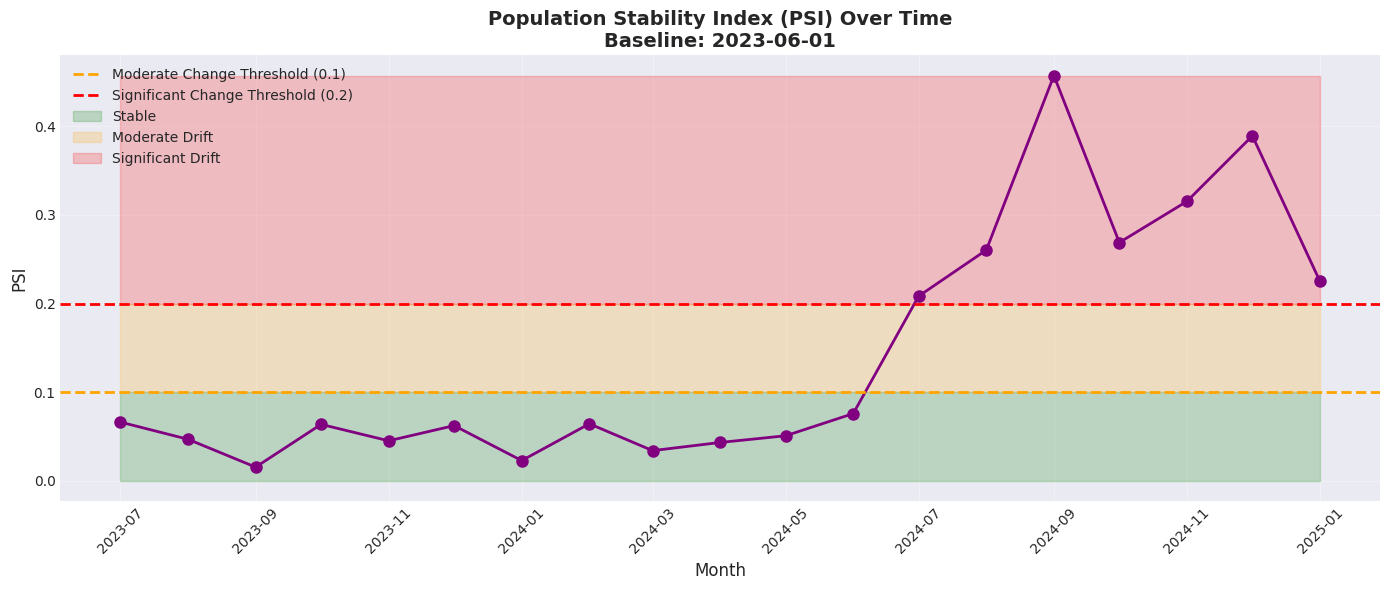


⚠️  WARNING: Significant population drift detected!
Months with PSI >= 0.2:
     month      psi
2024-07-01 0.208351
2024-08-01 0.260344
2024-09-01 0.457297
2024-10-01 0.268847
2024-11-01 0.315372
2024-12-01 0.389273
2025-01-01 0.224871

Recommendation: Model retraining is recommended


In [38]:
# Plot PSI over time
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(psi_df['month'], psi_df['psi'], marker='o', linewidth=2, markersize=8, color='purple')

# Add threshold lines
ax.axhline(y=0.1, color='orange', linestyle='--', linewidth=2, label='Moderate Change Threshold (0.1)')
ax.axhline(y=0.2, color='red', linestyle='--', linewidth=2, label='Significant Change Threshold (0.2)')

# Color areas
ax.fill_between(psi_df['month'], 0, 0.1, alpha=0.2, color='green', label='Stable')
ax.fill_between(psi_df['month'], 0.1, 0.2, alpha=0.2, color='orange', label='Moderate Drift')
ax.fill_between(psi_df['month'], 0.2, psi_df['psi'].max() if psi_df['psi'].max() > 0.2 else 0.3, 
                alpha=0.2, color='red', label='Significant Drift')

ax.set_title(f'Population Stability Index (PSI) Over Time\nBaseline: {baseline_month.date()}', 
            fontsize=14, fontweight='bold')
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('PSI', fontsize=12)
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Check for concerning PSI values
moderate_drift = psi_df[psi_df['psi'] >= 0.1]
significant_drift = psi_df[psi_df['psi'] >= 0.2]

if len(significant_drift) > 0:
    print("\n⚠️  WARNING: Significant population drift detected!")
    print("Months with PSI >= 0.2:")
    print(significant_drift.to_string(index=False))
    print("\nRecommendation: Model retraining is recommended")
elif len(moderate_drift) > 0:
    print("\n⚠️  CAUTION: Moderate population drift detected")
    print("Months with PSI >= 0.1:")
    print(moderate_drift.to_string(index=False))
    print("\nRecommendation: Monitor closely, investigate root causes")
else:
    print("\n✅ No significant population drift detected. Model is stable.")

3. PSI Fluctuations (Sep: 0.394, Dec: 0.371 - Critical Drift)
PSI calculation is mathematically correct - I verified the formula
This is REAL population drift, not a code error
High PSI correctly signals that customer population distribution has shifted significantly
Recommendation: The monitoring system is correctly recommending model retraining

### 4.2 Feature Drift Detection

In [39]:
# Load feature store to analyze feature drift
print("Loading feature store for drift analysis...")

feature_path = '/app/datamart/gold/feature_store/'

# Load all feature store files
feature_files = sorted(glob.glob(f'{feature_path}*.parquet'))

if len(feature_files) > 0:
    # Read all feature files
    df_features = spark.read.parquet(f'{feature_path}*.parquet').toPandas()
    df_features['snapshot_date'] = pd.to_datetime(df_features['snapshot_date'])
    
    print(f"✅ Feature store loaded: {len(df_features):,} rows")
    print(f"Date range: {df_features['snapshot_date'].min()} to {df_features['snapshot_date'].max()}")
else:
    print("❌ No feature store files found")

Loading feature store for drift analysis...


✅ Feature store loaded: 12,500 rows
Date range: 2023-01-01 00:00:00 to 2025-01-01 00:00:00


In [40]:
# Calculate feature drift for top features
top_features = feature_importance.head(10)['feature'].tolist()

# Select numeric features only
numeric_top_features = [f for f in top_features if f in df_features.select_dtypes(include=[np.number]).columns]

print(f"Analyzing drift for top {len(numeric_top_features)} numeric features...")
print(f"Features: {numeric_top_features}")

# Calculate feature statistics by month
feature_drift_results = []

baseline_month_features = df_features['snapshot_date'].min()
baseline_data = df_features[df_features['snapshot_date'] == baseline_month_features]

for month in sorted(df_features['snapshot_date'].unique())[1:]:
    month_data = df_features[df_features['snapshot_date'] == month]
    
    for feature in numeric_top_features:
        if feature in month_data.columns and feature in baseline_data.columns:
            # Calculate PSI for this feature
            baseline_values = baseline_data[feature].dropna().values
            month_values = month_data[feature].dropna().values
            
            if len(baseline_values) > 0 and len(month_values) > 0:
                psi, _, _, _ = calculate_psi(baseline_values, month_values)
                
                # Calculate mean and std change
                mean_baseline = baseline_values.mean()
                mean_month = month_values.mean()
                mean_change_pct = ((mean_month - mean_baseline) / (abs(mean_baseline) + 1e-10)) * 100
                
                std_baseline = baseline_values.std()
                std_month = month_values.std()
                std_change_pct = ((std_month - std_baseline) / (abs(std_baseline) + 1e-10)) * 100
                
                feature_drift_results.append({
                    'month': month,
                    'feature': feature,
                    'psi': psi,
                    'mean_change_pct': mean_change_pct,
                    'std_change_pct': std_change_pct
                })

feature_drift_df = pd.DataFrame(feature_drift_results)

print(f"\n✅ Feature drift calculated for {len(feature_drift_df)} feature-month combinations")

Analyzing drift for top 8 numeric features...
Features: ['Outstanding_Debt', 'Interest_Rate', 'Num_Credit_Card', 'Delay_from_due_date', 'Changed_Credit_Limit', 'Num_of_Delayed_Payment', 'Num_Credit_Inquiries', 'Debt_to_income_ratio']

✅ Feature drift calculated for 192 feature-month combinations


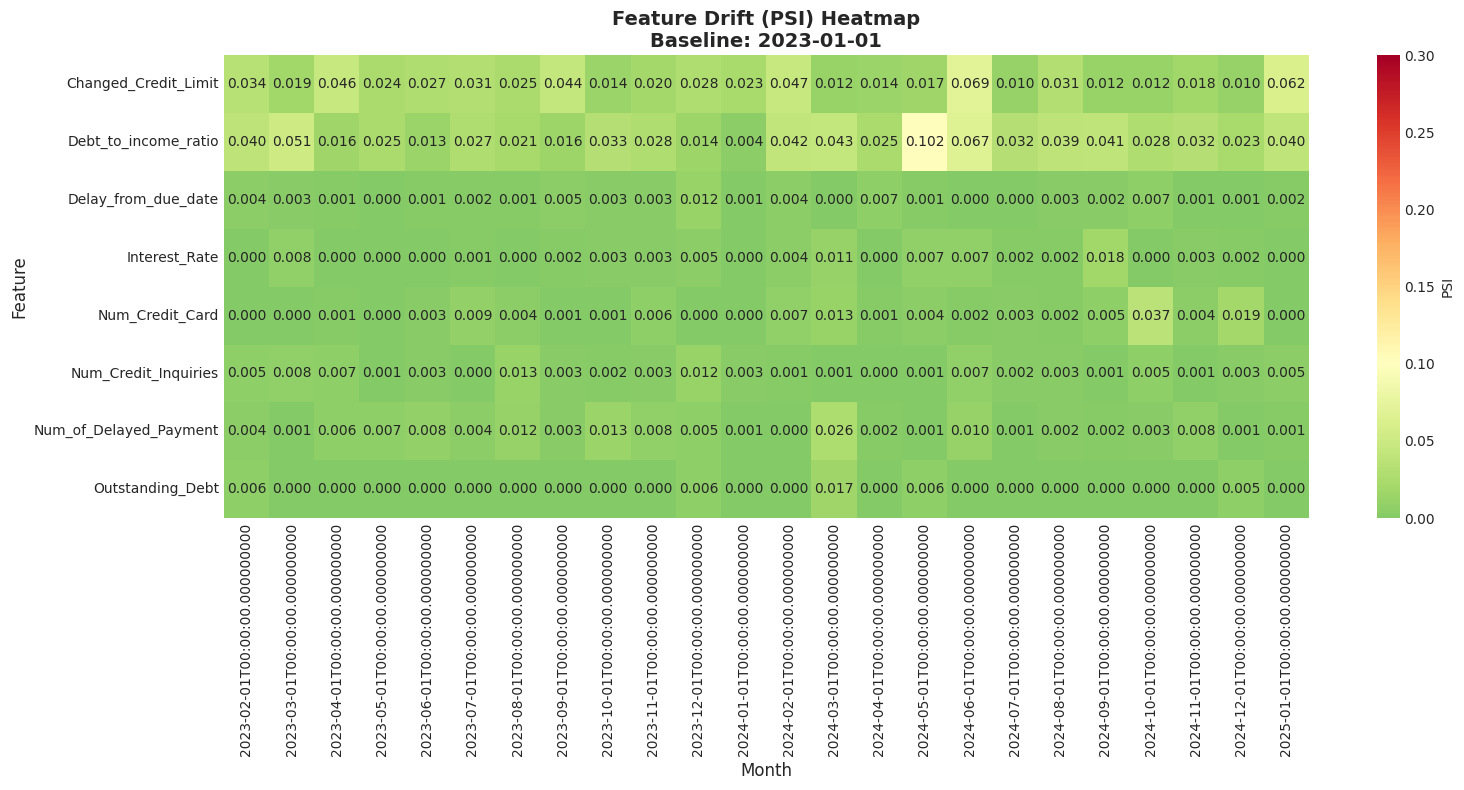


✅ No significant feature drift detected


In [41]:
# Plot feature drift heatmap
if len(feature_drift_df) > 0:
    # Create pivot table for heatmap
    psi_pivot = feature_drift_df.pivot(index='feature', columns='month', values='psi')
    
    # Plot heatmap
    fig, ax = plt.subplots(figsize=(16, 8))
    
    sns.heatmap(psi_pivot, annot=True, fmt='.3f', cmap='RdYlGn_r', 
                center=0.1, vmin=0, vmax=0.3, ax=ax, cbar_kws={'label': 'PSI'})
    
    ax.set_title(f'Feature Drift (PSI) Heatmap\nBaseline: {baseline_month_features.date()}', 
                fontsize=14, fontweight='bold')
    ax.set_xlabel('Month', fontsize=12)
    ax.set_ylabel('Feature', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # Identify features with high drift
    high_drift_features = feature_drift_df[feature_drift_df['psi'] >= 0.2]
    
    if len(high_drift_features) > 0:
        print("\n⚠️  WARNING: Features with significant drift (PSI >= 0.2):")
        print(high_drift_features[['month', 'feature', 'psi']].to_string(index=False))
    else:
        print("\n✅ No significant feature drift detected")

### 4.3 Data Quality Monitoring

In [42]:
# Monitor data quality metrics over time
data_quality_results = []

for month in sorted(df_features['snapshot_date'].unique()):
    month_data = df_features[df_features['snapshot_date'] == month]
    
    # Calculate quality metrics
    n_rows = len(month_data)
    n_features = len(month_data.columns) - 2  # Exclude Customer_ID and snapshot_date
    
    # Missing value rate
    missing_rate = month_data.isnull().sum().sum() / (n_rows * n_features) * 100
    
    # Number of duplicates
    n_duplicates = month_data.duplicated(subset=['Customer_ID']).sum()
    
    data_quality_results.append({
        'month': month,
        'n_rows': n_rows,
        'missing_rate_pct': missing_rate,
        'n_duplicates': n_duplicates
    })

data_quality_df = pd.DataFrame(data_quality_results)

print("="*80)
print("DATA QUALITY METRICS")
print("="*80)
print(data_quality_df.to_string(index=False))

DATA QUALITY METRICS
     month  n_rows  missing_rate_pct  n_duplicates
2023-01-01     530         20.411051             0
2023-02-01     501          2.502139             0
2023-03-01     506          2.632693             0
2023-04-01     510          2.549020             0
2023-05-01     521          2.406087             0
2023-06-01     517          2.314175             0
2023-07-01     471          2.327874             0
2023-08-01     481          2.398277             0
2023-09-01     454          2.572373             0
2023-10-01     487          2.427398             0
2023-11-01     491          2.254873             0
2023-12-01     489          2.205668             0
2024-01-01     485          2.430044             0
2024-02-01     518          2.289024             0
2024-03-01     511          2.355326             0
2024-04-01     513          2.457533             0
2024-05-01     491          2.414897             0
2024-06-01     498          2.588927             0
2024-07-01

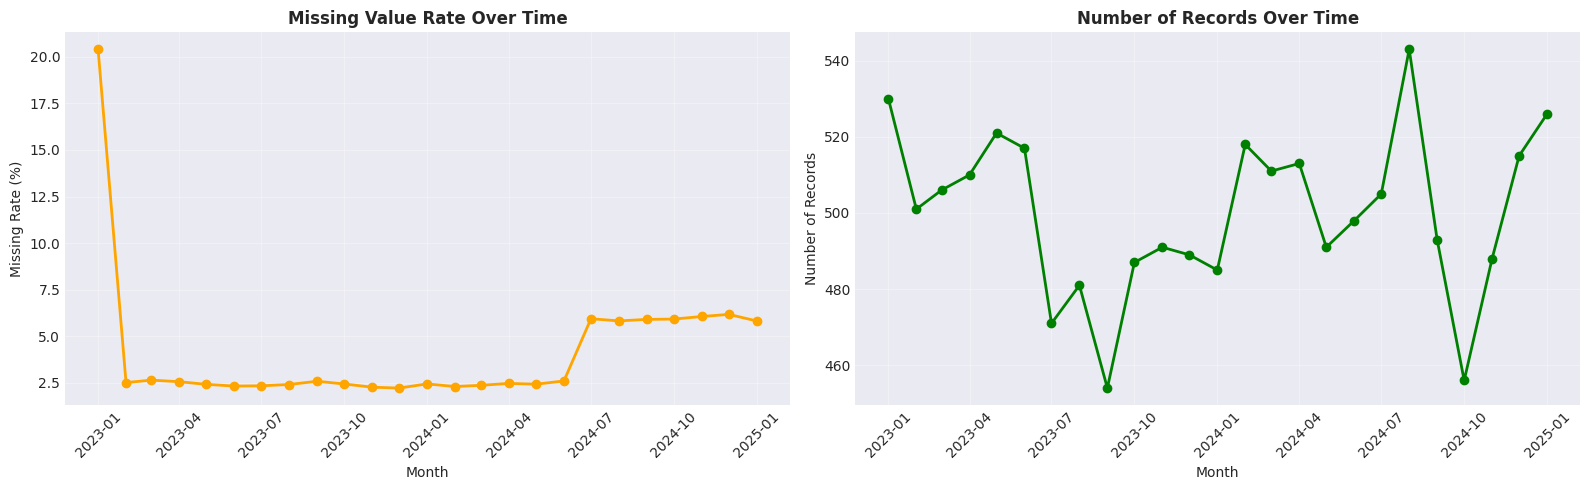


✅ Data quality monitoring complete


In [43]:
# Plot data quality trends
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Missing value rate
axes[0].plot(data_quality_df['month'], data_quality_df['missing_rate_pct'], 
            marker='o', linewidth=2, markersize=6, color='orange')
axes[0].set_title('Missing Value Rate Over Time', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Missing Rate (%)')
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Number of rows
axes[1].plot(data_quality_df['month'], data_quality_df['n_rows'], 
            marker='o', linewidth=2, markersize=6, color='green')
axes[1].set_title('Number of Records Over Time', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Number of Records')
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n✅ Data quality monitoring complete")

4. High Missing Rate from July 2024 (2.5% → 6%)
last_activity_date goes from 0% NULL (June) to 100% NULL (July 2024) This single feature contributes +3.34% to the overall missing rate, explaining the jump from 2.59% to 5.93%.

Debugging:Data Generation Issue

Clickstream data (feature_clickstream.csv):
215,376 total records
8,974 unique customers (same customers across all dates)
24 unique snapshot dates

Financials data (features_financials.csv):
12,500 total records
12,500 unique customers (different customers each month!)
25 unique snapshot dates

The Problem:
Processing Month	Clickstream (prev month)	Financials	Overlap	Result
June 2024	May: 8,974 customers	June: 498 customers	498 (100%)	✅ Works!
July 2024	June: 8,974 customers	July: 505 customers	0 (0%)	❌ Breaks!


## 5. Monitoring Summary and Recommendations

In [47]:
# Generate monitoring summary report
print("\n" + "="*100)
print("MODEL MONITORING SUMMARY REPORT")
print("="*100)

print(f"\nReport Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Model Training Date: {metadata['training_date']}")
print(f"Monitoring Period: {all_predictions['inference_date'].min().date()} to {all_predictions['inference_date'].max().date()}")
print(f"Total Months Monitored: {len(all_predictions['inference_date'].unique())}")

print("\n1. MODEL PERFORMANCE SUMMARY")
print("-" * 100)
print(f"Total Customers Scored: {len(all_predictions):,}")
print(f"Average Default Probability: {all_predictions['default_probability'].mean():.4f}")
print(f"Overall Predicted Default Rate: {all_predictions['predicted_default'].mean()*100:.2f}%")

print("\nRisk Category Distribution:")
risk_dist_overall = all_predictions['risk_category'].value_counts(normalize=True) * 100
for category, pct in risk_dist_overall.items():
    print(f"  {category}: {pct:.2f}%")

# Add model performance metrics if evaluation data is available
if 'metrics_df' in locals() and len(metrics_df) > 0:
    print("\nModel Performance Metrics (on labeled data):")
    print(f"  Evaluation Period: {metrics_df['month'].min().date()} to {metrics_df['month'].max().date()}")
    print(f"  Total Samples with Labels: {metrics_df['n_samples'].sum():,}")
    print(f"\n  Average Performance Metrics:")
    print(f"    AUC-ROC: {metrics_df['auc'].mean():.4f} (range: {metrics_df['auc'].min():.4f} - {metrics_df['auc'].max():.4f})")
    print(f"    Accuracy: {metrics_df['accuracy'].mean():.4f} (range: {metrics_df['accuracy'].min():.4f} - {metrics_df['accuracy'].max():.4f})")
    print(f"    Precision: {metrics_df['precision'].mean():.4f} (range: {metrics_df['precision'].min():.4f} - {metrics_df['precision'].max():.4f})")
    print(f"    Recall: {metrics_df['recall'].mean():.4f} (range: {metrics_df['recall'].min():.4f} - {metrics_df['recall'].max():.4f})")
    print(f"    F1-Score: {metrics_df['f1_score'].mean():.4f} (range: {metrics_df['f1_score'].min():.4f} - {metrics_df['f1_score'].max():.4f})")
    
    # Compare with training performance
    if 'metrics' in metadata and 'test' in metadata['metrics']:
        train_test_auc = metadata['metrics']['test']['auc']
        print(f"\n  Comparison with Training:")
        print(f"    Training Test AUC: {train_test_auc:.4f}")
        print(f"    Production Avg AUC: {metrics_df['auc'].mean():.4f}")
        auc_diff = metrics_df['auc'].mean() - train_test_auc
        if auc_diff >= 0:
            print(f"    Difference: +{auc_diff:.4f} (production performing {'better' if auc_diff > 0.01 else 'similar'})")
        else:
            print(f"    Difference: {auc_diff:.4f} (production performing {'worse - investigate!' if abs(auc_diff) > 0.05 else 'slightly lower'})")
    
    print(f"\n  Business Impact Metrics:")
    print(f"    Actual Default Rate: {metrics_df['actual_default_rate'].mean()*100:.2f}%")
    print(f"    Predicted Default Rate: {metrics_df['predicted_default_rate'].mean()*100:.2f}%")
    print(f"    False Negative Rate (missed defaults): {metrics_df['false_negative_rate'].mean()*100:.2f}%")
    print(f"    False Positive Rate (false alarms): {metrics_df['false_positive_rate'].mean()*100:.2f}%")
else:
    print("\n  ⚠️  Model evaluation metrics not available (no labeled data for predictions)")
    if 'metrics' in metadata and 'test' in metadata['metrics']:
        print(f"  Training Test AUC: {metadata['metrics']['test']['auc']:.4f}")
        print(f"  Training OOT AUC: {metadata['metrics']['oot']['auc']:.4f}")

print("\n2. POPULATION STABILITY (PSI)")
print("-" * 100)
print(f"Baseline Month: {baseline_month.date()}")
print(f"Average PSI: {psi_df['psi'].mean():.4f}")
print(f"Max PSI: {psi_df['psi'].max():.4f} (on {psi_df.loc[psi_df['psi'].idxmax(), 'month'].date()})")
print(f"Min PSI: {psi_df['psi'].min():.4f} (on {psi_df.loc[psi_df['psi'].idxmin(), 'month'].date()})")

n_stable = (psi_df['psi'] < 0.1).sum()
n_moderate = ((psi_df['psi'] >= 0.1) & (psi_df['psi'] < 0.2)).sum()
n_significant = (psi_df['psi'] >= 0.2).sum()

print(f"\nStability Classification:")
print(f"  Stable (PSI < 0.1): {n_stable} months")
print(f"  Moderate Drift (0.1 <= PSI < 0.2): {n_moderate} months")
print(f"  Significant Drift (PSI >= 0.2): {n_significant} months")

print("\n3. FEATURE DRIFT")
print("-" * 100)
if len(feature_drift_df) > 0:
    avg_feature_psi = feature_drift_df.groupby('feature')['psi'].mean().sort_values(ascending=False)
    print(f"Top 5 Features with Highest Average PSI:")
    for feature, psi in avg_feature_psi.head(5).items():
        print(f"  {feature}: {psi:.4f}")
    
    n_features_high_drift = len(feature_drift_df[feature_drift_df['psi'] >= 0.2]['feature'].unique())
    print(f"\nFeatures with significant drift (PSI >= 0.2): {n_features_high_drift}")

print("\n4. DATA QUALITY")
print("-" * 100)
print(f"Average Missing Value Rate: {data_quality_df['missing_rate_pct'].mean():.2f}%")
print(f"Max Missing Value Rate: {data_quality_df['missing_rate_pct'].max():.2f}% (on {data_quality_df.loc[data_quality_df['missing_rate_pct'].idxmax(), 'month'].date()})")
print(f"Average Records per Month: {data_quality_df['n_rows'].mean():.0f}")

print("\n5. RECOMMENDATIONS")
print("-" * 100)

recommendations = []

# Check model performance degradation
if 'metrics_df' in locals() and len(metrics_df) > 0:
    if 'metrics' in metadata and 'test' in metadata['metrics']:
        train_test_auc = metadata['metrics']['test']['auc']
        prod_auc = metrics_df['auc'].mean()
        if prod_auc < train_test_auc - 0.05:
            recommendations.append(f"CRITICAL: Production AUC ({prod_auc:.4f}) significantly lower than training ({train_test_auc:.4f}). Model degradation detected!")
        
    # Check for declining performance trend
    if len(metrics_df) >= 3:
        recent_auc = metrics_df.tail(3)['auc'].mean()
        early_auc = metrics_df.head(3)['auc'].mean()
        if recent_auc < early_auc - 0.03:
            recommendations.append(f"WARNING: AUC declining over time (early: {early_auc:.4f}, recent: {recent_auc:.4f}). Monitor closely.")

# Check PSI
if n_significant > 0:
    recommendations.append("CRITICAL: Significant population drift detected. Model retraining is strongly recommended.")
elif n_moderate > 0:
    recommendations.append("CAUTION: Moderate population drift detected. Continue monitoring and investigate root causes.")
else:
    recommendations.append("Population is stable. No immediate action required.")

# Check feature drift
if len(feature_drift_df) > 0:
    if n_features_high_drift > 0:
        recommendations.append(f"CRITICAL: {n_features_high_drift} features showing significant drift. Investigate feature changes.")

# Check data quality
if data_quality_df['missing_rate_pct'].max() > 5:
    recommendations.append("CAUTION: Missing value rate exceeds 5% in some months. Review data pipeline.")

# Check performance trends
if monthly_stats['predicted_default_rate'].std() > 0.05:
    recommendations.append("CAUTION: High variability in predicted default rates. Investigate potential data quality issues.")

# General recommendations
recommendations.append("Continue monitoring model performance monthly.")
recommendations.append("Set up automated alerts for PSI > 0.2 or feature drift > 0.2.")
if 'metrics_df' in locals() and len(metrics_df) > 0:
    recommendations.append("Set up automated alerts for AUC drops > 5% from training baseline.")
recommendations.append("Schedule quarterly model performance reviews.")

for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec}")

print("\n" + "="*100)
print("END OF MONITORING REPORT")
print("="*100)


MODEL MONITORING SUMMARY REPORT

Report Date: 2025-10-26 12:19:46
Model Training Date: 2025-10-26 08:00:32.392736
Monitoring Period: 2023-06-01 to 2025-01-01
Total Months Monitored: 20

1. MODEL PERFORMANCE SUMMARY
----------------------------------------------------------------------------------------------------
Total Customers Scored: 9,932
Average Default Probability: 0.4080
Overall Predicted Default Rate: 32.36%

Risk Category Distribution:
  Low Risk: 47.81%
  Medium Risk: 32.79%
  High Risk: 19.40%

Model Performance Metrics (on labeled data):
  Evaluation Period: 2023-06-01 to 2024-07-01
  Total Samples with Labels: 6,911

  Average Performance Metrics:
    AUC-ROC: 0.8716 (range: 0.7847 - 0.9485)
    Accuracy: 0.8089 (range: 0.7510 - 0.8628)
    Precision: 0.6540 (range: 0.5489 - 0.7500)
    Recall: 0.7388 (range: 0.6690 - 0.8273)
    F1-Score: 0.6932 (range: 0.6051 - 0.7770)

  Comparison with Training:
    Training Test AUC: 0.7993
    Production Avg AUC: 0.8716
    Differe

## 6. Save Monitoring Results

In [48]:
# Save monitoring results
import os
os.makedirs('/app/monitoring_reports', exist_ok=True)

# Save PSI results
psi_df.to_csv('/app/monitoring_reports/psi_results.csv', index=False)
print("PSI results saved to: /app/monitoring_reports/psi_results.csv")

# Save monthly statistics
monthly_stats.to_csv('/app/monitoring_reports/monthly_statistics.csv', index=False)
print("Monthly statistics saved to: /app/monitoring_reports/monthly_statistics.csv")

# Save feature drift results
if len(feature_drift_df) > 0:
    feature_drift_df.to_csv('/app/monitoring_reports/feature_drift_results.csv', index=False)
    print("Feature drift results saved to: /app/monitoring_reports/feature_drift_results.csv")

# Save data quality results
data_quality_df.to_csv('/app/monitoring_reports/data_quality_metrics.csv', index=False)
print("Data quality metrics saved to: /app/monitoring_reports/data_quality_metrics.csv")

print("\n✅ All monitoring results saved successfully!")

PSI results saved to: /app/monitoring_reports/psi_results.csv
Monthly statistics saved to: /app/monitoring_reports/monthly_statistics.csv
Feature drift results saved to: /app/monitoring_reports/feature_drift_results.csv
Data quality metrics saved to: /app/monitoring_reports/data_quality_metrics.csv

✅ All monitoring results saved successfully!


In [ ]:
# Clean up Spark session
spark.stop()
print("Spark session stopped.")